In [1]:
import sys
import os
sys.path.append(os.path.abspath(".."))

In [6]:
# Importing the required libraries
import numpy as np     # Library for working with arrays and mathematical functions.
import random          # Module to generate random values.
import matplotlib.pyplot as plt  # Library for generating plots and visualizing data.
from utils import temana as tm  # 'temana' module, for working with interpolation or spline functions.

### Efficient Generation of Frequency Reference Points for Signal Analysis

In [3]:
def generate_frequency_reference_points(x0, x1, f_low_range=(1, 5), f_high_range=(20, 60), n_partitions=10, n_min=1, n_max=8):
    """
    This function generates frequency reference points along an interval [x0, x1]. The frequency
    alternates between high and low frequencies based on a random selection, with more weight
    given to low and mid-range frequencies. High frequencies are included with lower probability.

    Arguments:
    x0              -- Start of the interval (on the X-axis).
    x1              -- End of the interval (on the X-axis).
    f_low_range     -- A tuple (min, max) representing the range of low frequencies (default is (1, 5) Hz).
    f_high_range    -- A tuple (min, max) representing the range of high frequencies (default is (20, 60) Hz).
    num_f_low       -- Number of low frequencies to randomly generate within the f_low_range (default is 10).
    num_f_high      -- Number of high frequencies to randomly generate within the f_high_range (default is 10).
    n_min           -- Minimum number of points where the frequency changes (default is 1).
    n_max           -- Maximum number of points where the frequency changes (default is 8).

    Returns:
    points -- A list of tuples, where each tuple contains a point on the X-axis and an associated frequency on the Y-axis.
    """

    # Randomly choose high frequencies within the specified range.
    f_high = np.random.uniform(f_high_range[0], f_high_range[1], n_partitions)
    f_high = np.sort(f_high)  # Sort frequencies from lowest to highest.
    
    # Randomly choose low frequencies within the specified range.
    f_low = np.random.uniform(f_low_range[0], f_low_range[1], n_partitions)
    f_low = np.sort(f_low)  # Sort frequencies from lowest to highest.
    
    # Randomly select the number of frequency change points between n_min and n_max.
    num_points = random.randint(n_min, n_max)
    
    # Divide the interval [x0, x1] into (num_points + 2) equal parts to define frequency change points.
    partition = np.linspace(x0, x1, num_points + 2)
    
    points = []  # List to store the frequency change points (x, y).
    
    # Initialize the type of frequency variation, which can be low ("low") or high ("high").
    variation_type = np.random.choice(["low", "high"])
    
    # Initialize the frequency (y), which will depend on the type of variation.
    y = 1  # Arbitrary initial value, to be modified later.
    
    # Iterate over the partition points.
    for i in range(num_points + 2):
        x = partition[i]  # Points on the X-axis.

        # For the first point, select a low or high frequency.
        if i == 0:            
            if variation_type == "low":
                y = np.random.choice(f_low)
            else:
                y = np.random.choice(f_high)
        else:
            # For subsequent points, randomly decide whether to change the frequency to low, high, or maintain ("no_change").
            variation_type = np.random.choice(["low", "high", "no_change"])
            
            if variation_type == "low":
                y = np.random.choice(f_low)
            elif variation_type == "high":
                y = np.random.choice(f_high)
            # If variation_type is "no_change", the value of y remains unchanged, i.e., the previous frequency is maintained.
        
        # Add the point (x, y) to the list of points.
        points.append((x, y))
    
    # Return the list of generated points, where each point is a tuple (x, frequency).
    return points

In [4]:
# Generation of frequency reference points for the interval [0, 4*pi].
points = generate_frequency_reference_points(0, 4 * np.pi)
points

[(0.0, 49.615373533369386),
 (4.1887902047863905, 3.2104955852680837),
 (8.377580409572781, 3.2104955852680837),
 (12.566370614359172, 34.040608043414764)]

### Dynamic Signal Generation with Frequency Variation

In [10]:
def generate_signal_with_frequency_variation(x, xm, tau_values=[1, 3, 5, 8, 10, 12, 15, 20], amplitude_range=(1, 6), translation_range=(1, 10), sine_cosine_choice_range=(0, 2)):
    """
    Function to generate signals with frequency changes based on reference points and splines.
    
    Parameters:
    x                 -- Data vector for super-sampling (vector with a high density of points).
    xm                -- Data vector for sub-sampling (vector with a lower density of points).
    tau_values        -- A list with possible values for the spline tension parameter 'tau'.
    amplitude_range   -- A tuple (min, max) defining the range for random amplitude values.
    translation_range -- A tuple (min, max) defining the range for random translation in time (C).
    sine_cosine_choice_range -- A tuple defining the range of values for choosing between sine (0) and cosine (1).
    
    Returns:
    y   -- Signal generated in the super-sampling space (high density of points).
    ym  -- Signal generated in the sub-sampling space (low density of points).
    """
    
    # Generate the frequency change function using the generate_frequency_reference_points function.
    points = generate_frequency_reference_points(x[0], x[-1])
    
    # Unpack the generated points into xf (X-axis) and yf (frequency).
    xf, yf = zip(*points)
    
    # Tau is selected randomly from the given tau_values.
    tau = np.random.choice(tau_values)
    
    # Random parameters for signal generation.
    choose = np.random.randint(sine_cosine_choice_range[0], sine_cosine_choice_range[1], 1)  # Select between sine or cosine.
    choose2 = np.random.randint(sine_cosine_choice_range[0], sine_cosine_choice_range[1], 1) # Choose between different types of splines.
    
    # Generate amplitude randomly in the given range, scaled by a random factor.
    A = (2 * np.random.rand() - 1) * np.random.randint(amplitude_range[0], amplitude_range[1], 1)
    
    # Use the spline function to interpolate over the frequencies yf.
    B = tm.tension_spline_interpolator(xf, yf, tau)  # Spline interpolation for frequency variation.
    
    # Random translation in time (C) and random phase (D) for the signal.
    C = (2 * np.random.rand() - 1) * np.random.randint(translation_range[0], translation_range[1], 1)  # Translation.
    D = np.random.rand() * np.pi  # Phase.
    
    # Generate additional reference points for sub-sampling.
    points = tm.generate_amplitude_change_points(xm[0], xm[-1])
    
    # Generate the signal using either sine or cosine based on 'choose'.
    if choose == 0:
        y = A * np.sin(B(x) * (x - D))  # Super-sampling signal.
        ym = A * np.sin(B(xm) * (xm - D))  # Sub-sampling signal.
    else:
        y = A * np.cos(B(x) * (x - D))  # Super-sampling signal.
        ym = A * np.cos(B(xm) * (xm - D))  # Sub-sampling signal.
    
    # Generate reference points again for spline functions.
    points = tm.generate_amplitude_change_points(x[0], x[-1])
    
    # Unpack the generated points for the splines.
    xs, ys = zip(*points)
    
    # Select a new tau value randomly for the splines.
    tau = np.random.choice(tau_values)
    
    # Depending on 'choose2', apply different splines to the signal.
    if choose2 == 0:
        y = tm.tension_spline_interpolator(xs, ys, tau)(x) * y + C
        ym = tm.tension_spline_interpolator(xs, ys, tau)(xm) * ym + C
    else:
        y = tm.zero_order_spline_interpolator(points)(x) * y + C
        ym = tm.zero_order_spline_interpolator(points)(xm) * ym + C
    
    # Return the generated signals: one with super-sampling and one with sub-sampling.
    return [y, ym]

In [13]:
# Generation of the super-sampling vector (x) and sub-sampling vector (xm).
# Both vectors represent the domain (X-axis) for the signals.

# The 'x' vector has 5000 points evenly distributed between 0 and 4*pi.
# This vector is used for super-sampling, providing a high-resolution signal.
x = np.linspace(0, 4 * np.pi, 5000)

# The 'xm' vector has 1000 points evenly distributed between 0 and 4*pi.
# This vector is used for sub-sampling, providing a lower-resolution signal.
xm = np.linspace(0, 4 * np.pi, 1000)

# These two vectors allow generating signals with different levels of detail.
# Super-sampling (x) provides a denser and more precise signal, 
# while sub-sampling (xm) generates a "lighter" or less dense signal.

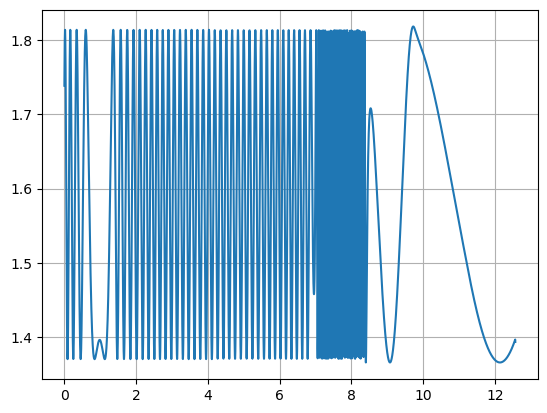

In [14]:
# Generation of signals with super-sampling (y) and sub-sampling (ym) using the function generate_signal_with_frequency_variation.
# 'x' is the super-sampling vector, and 'xm' is the sub-sampling vector.
y, ym = generate_signal_with_frequency_variation(x, xm)

# Visualization of the signal generated with super-sampling.
# The signal 'y' is plotted as a function of the vector 'x', which contains 5000 points between 0 and 4*pi.
plt.plot(x, y)

# Enable the grid on the plot to facilitate visualization of changes in the signal.
plt.grid()

# The super-sampled signal is displayed in a high-resolution plot.

### Generation of Non-Uniform Frequency Reference Points

In [15]:
def generate_non_uniform_frequency_points(x0, x1, low_freq_range=(1, 5), high_freq_range=(5, 60), num_low_freqs=10, num_high_freqs=10, min_points=2, max_points=11, low_prob=0.98, high_prob=0.02, change_low_prob=0.95, no_change_high_prob=0.05, maintain_prob=0.75):
    """
    Generates frequency reference points with a non-uniform partition (NU) across the interval [x0, x1].
    This function generates frequencies that change over time, giving more weight to low and mid-range frequencies,
    with a small probability of including high frequencies.

    Parameters:
    x0              -- Start of the interval (on the X-axis).
    x1              -- End of the interval (on the X-axis).
    low_freq_range  -- A tuple (min, max) representing the range of low frequencies (default is (1, 5) Hz).
    high_freq_range -- A tuple (min, max) representing the range of high frequencies (default is (5, 60) Hz).
    num_low_freqs   -- Number of low frequencies to generate randomly within the low_freq_range (default is 10).
    num_high_freqs  -- Number of high frequencies to generate randomly within the high_freq_range (default is 10).
    min_points      -- Minimum number of frequency change points (default is 2).
    max_points      -- Maximum number of frequency change points (default is 11).
    low_prob        -- Probability of selecting a low frequency (default is 0.98).
    high_prob       -- Probability of selecting a high frequency (default is 0.02).
    change_low_prob -- Probability of changing to a low frequency after a high frequency (default is 0.95).
    no_change_high_prob -- Probability of maintaining a high frequency (default is 0.05).
    maintain_prob   -- Probability of maintaining the current frequency (default is 0.75).

    Returns:
    points -- A list of tuples, where each tuple contains a point on the X-axis and an associated frequency on the Y-axis.
    types  -- A list indicating whether each point corresponds to a low ("low") or high ("high") frequency.
    """
    
    # Generate random high frequencies within the specified range.
    high_frequency = np.random.uniform(high_freq_range[0], high_freq_range[1], num_high_freqs)
    high_frequency = np.sort(high_frequency)  # Sort frequencies from lowest to highest.
    
    # Generate random low frequencies within the specified range.
    low_frequency = np.random.uniform(low_freq_range[0], low_freq_range[1], num_low_freqs)
    low_frequency = np.sort(low_frequency)  # Sort frequencies from lowest to highest.
    
    # Randomly select the number of frequency change points between min_points and max_points.
    num_points = random.randint(min_points, max_points)
    
    # Create an array 'tdom' to define the non-uniform partition. The partition is stored in 'partition'.
    # tdom represents fractions of the interval [0, 1], which is then scaled to the interval [x0, x1].
    tdom = np.zeros(num_points + 2)  # Initialize the array with zeros.
    tdom[-1] = 1  # The last value of 'tdom' will be 1 (representing the end of the interval).
    tdom[1:-1] = np.sort(np.random.rand(num_points))  # Random partitions between 0 and 1.
    
    # Scale 'tdom' to obtain the partition in the interval [x0, x1].
    partition = x0 + (x1 - x0) * tdom
    
    # Initialize a list to store the points (x, frequency) and the type of frequency.
    points = []
    types = []
    
    # Initialize the type of variation, with a high probability of low frequencies and a low probability of high frequencies.
    variation_type = np.random.choice(["low", "high"], p=[low_prob, high_prob])
    
    # Initialize the frequency 'y'.
    y = 1
    
    # Iterate over the partition points.
    for i in range(num_points + 2):
        x = partition[i]  # Point on the X-axis.
        
        if i == 0:
            # For the first point, select whether the frequency is low or high according to 'variation_type'.
            if variation_type == "low":
                y = np.random.choice(low_frequency)
                types.append("low")
            else:
                y = np.random.choice(high_frequency)
                types.append("high")
        else:
            # If the last frequency was high, force a change to a low frequency or maintain the same frequency.
            if types[-1] == "high":
                variation_type = np.random.choice(["low", "no_change"], p=[change_low_prob, no_change_high_prob])
            else:
                # If the last frequency was low, there is a higher probability to maintain it, with a lower probability of changing.
                variation_type = np.random.choice(["low", "high", "no_change"], p=[0.20, 0.05, maintain_prob])
            
            # Select the new frequency or maintain the current one.
            if variation_type == "low":
                y = np.random.choice(low_frequency)
                types.append(variation_type)
            elif variation_type == "high":
                y = np.random.choice(high_frequency)
                types.append(variation_type)
            else:
                # If it is 'no_change', the previous frequency is maintained.
                types.append(types[-1])
        
        # Add the point (x, frequency) to the list of points.
        points.append((x, y))
    
    # Return the partition points and the type of frequency at each point.
    return (points, types)

In [16]:
# We call the generate_non_uniform_frequency_points function to generate frequency reference points.
# The interval we are considering is from 0 to 4*pi.
# This means that the generated frequencies will be distributed in this non-uniform interval.

puntos = generate_non_uniform_frequency_points(0, 4 * np.pi)

# Print or evaluate the generated points.
puntos


([(0.0, 3.037664976365541),
  (1.1096861719995816, 3.037664976365541),
  (3.916192766869417, 3.037664976365541),
  (5.134740320984403, 1.501114438817948),
  (6.333611857950257, 1.501114438817948),
  (7.895367828374704, 1.501114438817948),
  (8.677238928596783, 3.037664976365541),
  (10.119749984895707, 3.037664976365541),
  (11.83957635287915, 3.037664976365541),
  (12.168160967380183, 1.4398264766980362),
  (12.566370614359172, 1.4398264766980362)],
 ['low', 'low', 'low', 'low', 'low', 'low', 'low', 'low', 'low', 'low', 'low'])

### Generate Signal with Non-Uniform Frequency Variation

In [17]:
# Function to generate signals with frequency changes using non-uniform partitions
# and splines to adjust the frequencies.
def generate_signal_with_non_uniform_frequency(x, xm, tau_values=[1, 1.1, 1.2, 1.3, 1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2], amplitude_range=(1, 6),
                                               translation_range=(1, 10), sine_cosine_choice_range=(0, 2), 
                                               spline_range=(1, 2), spline_resolution=21):
    """
    Generates signals with frequency changes based on reference points with non-uniform partitions (NU).
    
    Parameters:
    x               -- Data vector for super-sampling (high density of points).
    xm              -- Data vector for sub-sampling (lower density of points).
    tau_values      -- List of possible tau values to control the shape of the spline (default is None, which will use [1, 2]).
    amplitude_range -- Range (min, max) for the random amplitude (default is (-5, 5)).
    translation_range -- Range (min, max) for the random translation (default is (-10, 10)).
    choose_options  -- Tuple with possible values for selecting sine (0) or cosine (1) (default is (0, 1)).
    spline_range    -- Range for selecting the tau value to generate the spline (default is (1, 2)).
    spline_resolution -- Number of values to sample between the spline_range (default is 21).
    
    Returns:
    y  -- Signal generated in the super-sampling space.
    ym -- Signal generated in the sub-sampling space.
    """
    
    # Generate the frequency change function using non-uniform partitioning.
    points, types = generate_non_uniform_frequency_points(x[0], x[-1])  # Frequency points with non-uniform partition.
    xf, yf = zip(*points)  # Unpack the points (X-axis and frequencies).
    
    # Randomly select tau from the provided tau values.
    tau = np.random.choice(tau_values)
    
    print("Types:", types)  # Print the type of frequency variation (low or high) for each point.
    print("tau:", tau)       # Print the selected tau value.
    
    # Additional random parameters for generating the signal.
    choose = np.random.randint(sine_cosine_choice_range[0], sine_cosine_choice_range[1], 1)  # Select between sine or cosine.
    choose2 = np.random.randint(sine_cosine_choice_range[0], sine_cosine_choice_range[1], 1) # Choose between different types of splines.

    # Generate the amplitude randomly within the specified range.
    A = (2 * np.random.rand() - 1) * np.random.randint(amplitude_range[0], amplitude_range[1], 1)
    
    # Use the tm.tension_spline_interpolator function to generate a spline based on the points xf (X-axis) and yf (frequencies).
    B = tm.tension_spline_interpolator(xf, yf, tau)
    
    # Generate a random translation (C) and random phase (D) for the signal.
    C = (2 * np.random.rand() - 1) * np.random.randint(translation_range[0], translation_range[1], 1)  # Translation.
    D = np.random.rand() * np.pi  # Phase.
    
    # Generate additional reference points for sub-sampling.
    points = tm.generate_amplitude_change_points(xm[0], xm[-1])
    
    # Generate the signal using sine or cosine functions.
    if choose == 0:
        # Signal based on sine.
        y = A * np.sin(B(x) * (x - D))  # Signal in the super-sampling space.
        ym = A * np.sin(B(xm) * (xm - D))  # Signal in the sub-sampling space.
    else:
        # Signal based on cosine.
        y = A * np.cos(B(x) * (x - D))  # Signal in the super-sampling space.
        ym = A * np.cos(B(xm) * (xm - D))  # Signal in the sub-sampling space.
    
    # Generate reference points again to apply splines to the signal.
    points = tm.generate_amplitude_change_points(x[0], x[-1])
    xs, ys = zip(*points)  # Unpack the points.
    
    # Select a new tau value randomly for the splines within the spline range.
    tau = np.random.choice(np.linspace(spline_range[0], spline_range[1], spline_resolution))
    print("tau2:", tau)
    
    # Apply different types of splines to the signal depending on the value of 'choose2'.
    if choose2 == 0:
        # Apply a random tension spline over the original signal.
        y = tm.tension_spline_interpolator(xs, ys, tau)(x) * y + C
        ym = tm.tension_spline_interpolator(xs, ys, tau)(xm) * ym + C
    else:
        # Apply a spline with infinite tension (no curvature) to the signal.
        y = tm.zero_order_spline_interpolator(points)(x) * y + C
        ym = tm.zero_order_spline_interpolator(points)(xm) * ym + C

    # Return the generated signals (with super-sampling and sub-sampling).
    return [y, ym]

Types: ['low', 'low', 'low', 'low', 'low', 'low', 'high']
tau: 2.0
tau2: 1.5


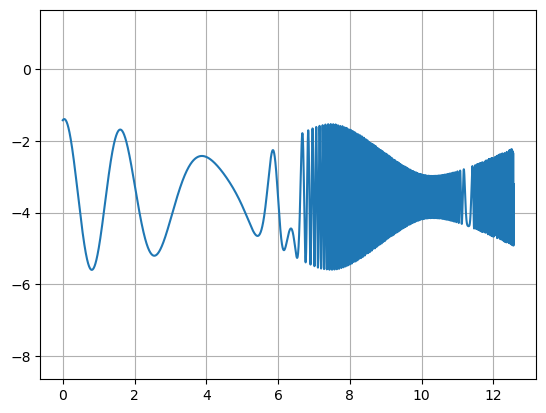

In [18]:
# Generation of signals with super-sampling (y1) and sub-sampling (ym2) using the function generate_signal_with_non_uniform_frequency.
# 'x' is the super-sampling vector (5000 points), and 'xm' is the sub-sampling vector (1000 points).
# The function returns two signals: 'y1' (super-sampling) and 'ym2' (sub-sampling).
y1, ym2 = generate_signal_with_non_uniform_frequency(x, xm)

# Visualization of the signal generated with super-sampling.
# The signal 'y1' is plotted as a function of the vector 'x', allowing observation of its variations.
plt.plot(x, y1)

# Configure the axes to have the same proportions on X and Y.
plt.axis("equal")

# Enable the grid on the plot to facilitate the visualization and analysis of the generated signal.
plt.grid()

# The 'y1' signal is displayed on the plot, with equal X and Y axes proportions.
# This allows for a more accurate representation of the generated signal's shape within the super-sampling interval.


### Generate Non-Uniform High and Low Frequency Points

In [22]:
# Function to generate signals with non-uniform partitioning for low and high frequencies.
def generate_non_uniform_high_low_frequency_points(x0, x1, low_freq_range=(1, 5), high_freq_range=(20, 100), 
                                                   num_low_freqs=10, num_high_freqs=10, min_points=2, max_points=11, 
                                                   low_prob=0.96, high_prob=0.04, 
                                                   change_to_low_prob=0.95, no_change_high_prob=0.05, 
                                                   maintain_low_prob=0.73, change_to_high_prob=0.07):
    """
    Generates frequency reference points with a non-uniform partition (NU), distinguishing between low and high frequencies.
    High frequencies are "carried" by low frequencies and occur less frequently, while low frequencies are more common.

    Parameters:
    x0                 -- Start of the interval (on the X-axis).
    x1                 -- End of the interval (on the X-axis).
    low_freq_range     -- Range for low frequencies (default is (1, 5) Hz).
    high_freq_range    -- Range for high frequencies (default is (20, 100) Hz).
    num_low_freqs      -- Number of low frequencies to generate (default is 10).
    num_high_freqs     -- Number of high frequencies to generate (default is 10).
    min_points         -- Minimum number of partition points (default is 2).
    max_points         -- Maximum number of partition points (default is 11).
    low_prob           -- Probability of selecting a low frequency (default is 0.96).
    high_prob          -- Probability of selecting a high frequency (default is 0.04).
    change_to_low_prob -- Probability of changing from high to low frequency (default is 0.95).
    no_change_high_prob -- Probability of maintaining a high frequency (default is 0.05).
    maintain_low_prob  -- Probability of maintaining a low frequency (default is 0.73).
    change_to_high_prob -- Probability of changing from low to high frequency (default is 0.07).

    Returns:
    points      -- A list of tuples (x, low_frequency) where each tuple contains a point on the X-axis and its associated low frequency.
    high_points -- A list of tuples (x, high_frequency) with points on the X-axis where a high frequency occurs. Zones without high frequency have a value of 0.
    types       -- A list indicating whether the frequency at each point is low ("low") or high ("high").
    """
    
    # Generate high frequencies within the specified range.
    high_frequency = np.random.uniform(high_freq_range[0], high_freq_range[1], num_high_freqs)
    high_frequency = np.sort(high_frequency)  # Sort high frequencies from lowest to highest.
    
    # Generate low frequencies within the specified range.
    low_frequency = np.random.uniform(low_freq_range[0], low_freq_range[1], num_low_freqs)
    low_frequency = np.sort(low_frequency)  # Sort low frequencies from lowest to highest.
    
    # Randomly select the number of frequency change points.
    num_points = random.randint(min_points, max_points)
    
    # Create an array to define the non-uniform partition over the interval [x0, x1].
    tdom = np.zeros(num_points + 2)  # Initialize the array.
    tdom[-1] = 1  # The last value of 'tdom' is 1 (representing the end of the interval).
    tdom[1:-1] = np.sort(np.random.rand(num_points))  # Random partitions between 0 and 1.
    partition = x0 + (x1 - x0) * tdom  # Scale 'tdom' to the interval [x0, x1].
    
    # Initialize lists to store low frequency points, high frequency points, and the frequency type.
    points = []  # Stores low-frequency points.
    types = []   # Stores the frequency type ("low" or "high").
    
    tdom_h = [tdom[0]]  # Stores high-frequency points.
    y_h = []  # Stores high-frequency values (will be 0 where there is no high frequency).
    
    # Initialize the type of variation (low or high) with the given probabilities.
    variation_type = np.random.choice(["low", "high"], p=[low_prob, high_prob])
    
    # Initialize the frequency 'y' to begin.
    y = 1
    
    # Iterate over the generated partition points.
    for i in range(num_points + 2):
        x = partition[i]  # Point on the X-axis.
        
        if i == 0:
            # For the first point, select whether the frequency is low or high.
            if variation_type == "low":
                y = np.random.choice(low_frequency)  # Select a low frequency.
                types.append("low")
                y_h.append(0)  # No high frequency at this point.
            else:
                y = np.random.choice(low_frequency)  # Low frequency to carry the high frequency.
                types.append("high")
                tdom_h.append(np.random.uniform(partition[i], partition[i+1], 1)[0])  # Point of high frequency.
                temp_high_freq = np.random.choice(high_frequency)  # Select a high frequency.
                y_h.append(temp_high_freq)
                y_h.append(temp_high_freq)
        else:
            # If the last frequency was high, force the change to low or maintain it.
            if types[-1] == "high":
                variation_type = np.random.choice(["low", "no_change"], p=[change_to_low_prob, no_change_high_prob])
            else:
                # For low frequencies, there is a higher probability of maintaining the frequency.
                variation_type = np.random.choice(["low", "high", "no_change"], p=[0.20, change_to_high_prob, maintain_low_prob])
            
            # Adjust the frequency based on the selection.
            if variation_type == "low":
                y = np.random.choice(low_frequency)
                y_h.append(0)  # No high frequency at this point.
                tdom_h.append(x)
                types.append("low")
            
            elif variation_type == "high":
                y = np.random.choice(low_frequency)  # Low frequency to carry the high frequency.
                types.append("high")
                tdom_h.append(x)
                if i != num_points + 1:
                    temp_high_freq = np.random.choice(high_frequency)  # New high frequency.
                    tdom_h.append(np.random.uniform(partition[i], partition[i+1], 1)[0])  # Point where high frequency occurs.
                    y_h.append(temp_high_freq)
                    y_h.append(temp_high_freq)
                else:
                    y_h.append(0)  # No high frequency at this point.
            
            else:
                # If no frequency change, maintain the previous type.
                types.append(types[-1])
                y_h.append(0)  # No high frequency.
                tdom_h.append(x)
        
        # Add the point (x, low frequency) to the list of points.
        points.append((x, y))
    
    # Pack the points where high frequencies occur.
    high_points = [(tdom_h[i], y_h[i]) for i in range(len(tdom_h))]
    
    # Return the low-frequency points, high-frequency points, and the type of each frequency.
    return (points, high_points, types)

points:  [(0.0, 1.5354168202862977), (0.06672237624165024, 1.5354168202862977), (2.676980089467182, 1.5354168202862977), (5.993683148233992, 3.743780216284325), (7.560189573795367, 3.0791310611697797), (12.566370614359172, 3.0791310611697797)]
points_h:  [(0.0, 0), (0.06672237624165024, 0), (2.676980089467182, 0), (5.993683148233992, 63.570682015085126), (6.026599847056534, 63.570682015085126), (7.560189573795367, 0), (12.566370614359172, 0)]
['low', 'low', 'low', 'high', 'low', 'low']


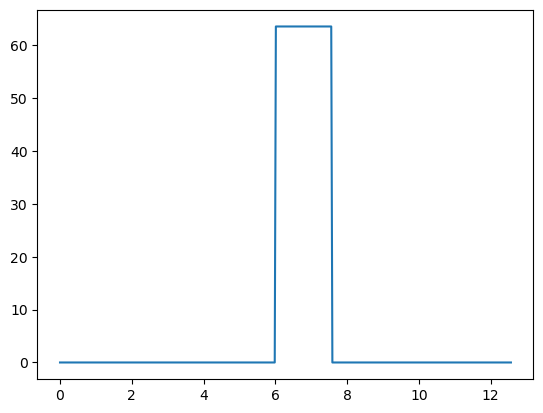

In [23]:
# Generate low and high frequency points using the generate_non_uniform_high_low_frequency_points function.
# The interval used is from 0 to 4*pi.
points, points_h, type_p = generate_non_uniform_high_low_frequency_points(0, 4 * np.pi)

# Print the low frequency points (points) and high frequency points (points_h), along with the frequency type at each point.
print("points: ", points)     # Low frequency points generated in the interval.
print("points_h: ", points_h) # Points where high frequencies occur (areas without high frequency have a value of 0).
print(type_p)                   # Shows whether each point has a "low" or "high" frequency.

# Generate a vector t with 400 points evenly distributed between 0 and 4*pi.
# This vector will represent the points where we will evaluate the generated signal.
t = np.linspace(0, 4 * np.pi, 400)

# Use the high frequency points (puntos_h) to generate the signal using the tm.zero_order_spline_interpolator function.
# tm.zero_order_spline_interpolator generates a tensionless spline, which will interpolate the high frequencies at the corresponding points.
yt = tm.zero_order_spline_interpolator(points_h)(t)

# Plot the generated signal (yt) as a function of time (t).
plt.plot(t, yt)

# The plot of the generated signal with spline interpolation for high frequencies is shown.
# Points where there is no high frequency will have a value of 0, which is reflected in the plot.


### Generation of Non-Uniform Frequency Signals with Noise

In [24]:
def generate_signal_with_nu_high_frequency(x, xm, tau_values=[1, 1.1, 1.2, 1.3, 1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2], amplitude_range=(1, 6), translation_range=(1, 10), noise_range=(0.08, 0.2), spline_range=(1, 2), spline_resolution=21, choose_prob=[0.98, 0.02]):
    """
    Generates signals with frequency changes based on reference points with non-uniform partitions (NU).
    It also adds noise to the signal to simulate a more realistic environment.

    Parameters:
    x               -- Data vector for super-sampling (with high point density).
    xm              -- Data vector for sub-sampling (with lower point density).
    tau_values      -- List of possible tau values to control spline tension.
    amplitude_range -- Range (min, max) for random amplitude generation.
    translation_range -- Range (min, max) for the random translation of the signal.
    noise_range     -- Range (min, max) for the random noise amplitude added to the signal.
    spline_range    -- Range for selecting the tau value to generate the spline.
    spline_resolution -- Number of values to sample between the spline_range.
    choose_prob     -- Probability distribution for selecting different spline types.

    Returns:
    y   -- Signal generated in the super-sampling space.
    ym  -- Signal generated in the sub-sampling space.
    noise -- Noise added to the signal to simulate variations.
    """
    
    # Generate the frequency change function using the non-uniform partition.
    points, high_points, types = generate_non_uniform_high_low_frequency_points(x[0], x[-1])
    
    # Unpack the generated points: 'xf' represents the X-axis points and 'yf' represents the associated frequencies.
    xf, yf = zip(*points)
    
    # Randomly select the tau parameter, which controls the tension of the spline.
    tau = np.random.choice(tau_values)
    
    print("Types:", types)  # Print the type of frequency variation (low or high) at each point.
    print("tau:", tau)      # Print the selected value of tau.
    
    # Generate additional random parameters:
    # 'choose' selects between sine or cosine, and 'choose2' selects between two types of splines with different probabilities.
    choose = np.random.choice([0, 1], 1)
    choose2 = np.random.choice([0, 1], 1, p=choose_prob)  # Custom probability for spline types.
    
    # Randomly generate the amplitude within the specified range.
    A = (2 * np.random.rand() - 1) * np.random.randint(amplitude_range[0], amplitude_range[1], 1)
    
    # Use the function tm.tension_spline_interpolator to generate a spline based on the points xf (X-axis) and yf (frequency).
    B = tm.tension_spline_interpolator(xf, yf, tau)
    
    # Generate a random translation (C) and phase (D) for the signal.
    C = (2 * np.random.rand() - 1) * np.random.randint(translation_range[0], translation_range[1], 1)  # Translation.
    D = np.random.rand() * np.pi   # Phase.
    
    # Generate the signal using sine or cosine depending on 'choose'.
    if choose == 0:
        # Signal based on sine.
        y = A * np.sin(B(x) * (x - D))  # Signal in the super-sampling space.
        ym = A * np.sin(B(xm) * (xm - D))  # Signal in the sub-sampling space.
    else:
        # Signal based on cosine.
        y = A * np.cos(B(x) * (x - D))  # Signal in the super-sampling space.
        ym = A * np.cos(B(xm) * (xm - D))  # Signal in the sub-sampling space.
    
    # Generate additional reference points to apply splines to the signal.
    points = tm.generate_amplitude_change_points(x[0], x[-1])
    xs, ys = zip(*points)  # Unpack the points.
    
    # Randomly select a new tau value for the splines within the spline range.
    tau = np.random.choice(np.linspace(spline_range[0], spline_range[1], spline_resolution))
    print("tau2:", tau)
    
    # Generate random noise to add to the signal, with an amplitude range between 0.08 and 0.2.
    noise_amplitude = np.random.uniform(noise_range[0], noise_range[1], 1)
    
    # Generate noise for super-sampling and sub-sampling using splines and sinusoidal signals.
    noise = noise_amplitude * tm.tension_spline_interpolator(xs, ys, tau)(x) * np.sin(tm.zero_order_spline_interpolator(high_points)(x) * x)
    noise_subsample = noise_amplitude * tm.tension_spline_interpolator(xs, ys, tau)(xm) * np.sin(tm.zero_order_spline_interpolator(high_points)(xm) * xm)
    
    # Depending on 'choose2', apply different types of splines to the signal.
    if choose2 == 0:
        # Apply a random tension spline over the original signal, also adding the noise.
        y = tm.tension_spline_interpolator(xs, ys, tau)(x) * y + C + noise
        ym = tm.tension_spline_interpolator(xs, ys, tau)(xm) * ym + C + noise_subsample
    else:
        # Apply a zero-tension spline to the signal, also adding the noise.
        y = tm.zero_order_spline_interpolator(points)(x) * y + C + noise
        ym = tm.zero_order_spline_interpolator(points)(xm) * ym + C + noise_subsample

    # Return the generated signals (with super-sampling and sub-sampling) along with the added noise.
    return [y, ym, noise]

In [25]:
# Generation of the super-sampling vector (x) and sub-sampling vector (xm).
# Both vectors represent the domain (X-axis) for the signals.

# The 'x' vector has 1000 points evenly distributed between 0 and 4*pi.
# This vector is used for super-sampling, providing a high-resolution signal.
x = np.linspace(0, 4 * np.pi, 1000)

# The 'xm' vector has 200 points evenly distributed between 0 and 4*pi.
# This vector is used for sub-sampling, providing a lower-resolution signal.
xm = np.linspace(0, 4 * np.pi, 200)

# These two vectors allow generating signals with different levels of detail.
# Super-sampling (x) provides a denser and more precise signal, 
# while sub-sampling (xm) generates a signal with fewer points, reducing the resolution.


Types: ['low', 'low', 'low', 'low', 'low', 'low', 'low', 'low']
tau: 1.0
tau2: 1.2


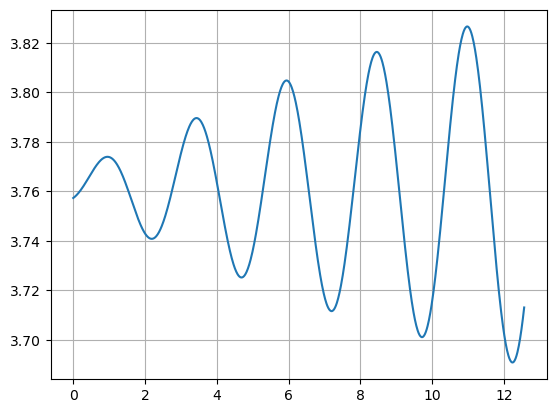

In [26]:
# Generation of signals with super-sampling (y) and sub-sampling (ym) using the function generate_signal_with_nu_high_frequency.
# Random noise is also generated and added to the signal.
# 'x' is the super-sampling vector (1000 points), and 'xm' is the sub-sampling vector (200 points).
y, ym, noise = generate_signal_with_nu_high_frequency(x, xm)

# Visualization of the signal generated with super-sampling.
# The signal 'y' is plotted as a function of the vector 'x', allowing observation of the generated variations.
plt.plot(x, y)

# Enable the grid on the plot to facilitate visualization of the signal.
plt.grid()

# The generated super-sampled signal is displayed on the plot.
# The signal 'y' includes frequency variations and the generated random noise.


###  Generation of Multiple Signals with Non-Uniform Frequency Variation and Noise

In [27]:
def generate_signal_list_with_nu_high_frequency(x, len_x, tau_values=[1, 1.1, 1.2, 1.3, 1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2], amplitude_range=(1, 6), translation_range=(1, 10), noise_amplitude_range=(0.08, 0.2), spline_range=(1, 2), spline_resolution=21, choose_prob=[0.98, 0.02]):
    """
    Generates signals with frequency changes based on reference points with non-uniform partitions (NU)
    for different sampling rates, adding noise to the generated signals.

    Parameters:
    x                    -- Data vector for super sampling (high-density points).
    len_x                -- List of sizes for different versions of the generated signal with subsampling.
                            Example: len_x = [250, 500, 1000].
    tau_values           -- List of possible tau values to control spline tension.
    amplitude_range      -- Range (min, max) for random amplitude generation.
    translation_range    -- Range (min, max) for random translation generation.
    noise_amplitude_range -- Range (min, max) for random noise amplitude.
    spline_range         -- Range for selecting the tau value to generate the spline.
    spline_resolution    -- Number of values to sample between the spline_range.
    choose_prob          -- Probability distribution for selecting different spline types (default is 98% chance of random tension spline).

    Returns:
    y        -- Signal generated in the super sampling space.
    list_y   -- List of signals generated with different sampling rates, according to len_x.
    noise    -- Noise added to the generated super-sampled signal.
    """
    
    # Generate frequency change functions using non-uniform partitioning.
    points, points_h, type = generate_non_uniform_high_low_frequency_points(x[0], x[-1])

    # Create a list of vectors for different sampling rates based on len_x.
    list_x = [np.linspace(x[0], x[-1], lx) for lx in len_x]

    # Unpack generated points: 'xf' are the X-axis points, and 'yf' are the associated frequencies.
    xf, yf = zip(*points)
    
    # Randomly select the tau parameter, which controls the spline's tension, from tau_values.
    tau = np.random.choice(tau_values)
    
    print("Type:", type)  # Print the type of frequency variation (low or high) for each point.
    print("tau:", tau)    # Print the selected tau value.
    
    # Generate additional random parameters:
    # 'choose' selects between sine or cosine, and 'choose2' selects between two types of splines with different probabilities.
    choose = np.random.choice([0, 1], 1)
    choose2 = np.random.choice([0, 1], 1, p=choose_prob)  # Custom probability for spline types.
    
    # Generate the amplitude randomly within the specified range.
    A = (2 * np.random.rand() - 1) * np.random.randint(amplitude_range[0], amplitude_range[1], 1)
    
    # Use the function tm.tension_spline_interpolator to generate a spline based on the xf (X-axis) and yf (frequency) points.
    B = tm.tension_spline_interpolator(xf, yf, tau)
    
    # Randomly generate the time translation (C) and phase (D) for the signal.
    C = (2 * np.random.rand() - 1) * np.random.randint(translation_range[0], translation_range[1], 1)  # Translation.
    D = np.random.rand() * np.pi  # Phase.
    
    # Generate the signal using sine or cosine depending on 'choose'.
    if choose == 0:
        # Signal based on sine for super sampling.
        y = A * np.sin(B(x) * (x - D))  
        # Generate signals with different sampling rates based on the list list_x.
        list_y = [A * np.sin(B(xm) * (xm - D)) for xm in list_x]  
    else:
        # Signal based on cosine for super sampling.
        y = A * np.cos(B(x) * (x - D))  
        # Generate signals with different sampling rates based on the list list_x.
        list_y = [A * np.cos(B(xm) * (xm - D)) for xm in list_x]
    
    # Generate additional reference points to apply splines to the signal.
    points = tm.generate_amplitude_change_points(x[0], x[-1])
    xs, ys = zip(*points)  # Unpack the points.

    # Randomly select a new tau value for the splines within the spline range.
    tau = np.random.choice(np.linspace(spline_range[0], spline_range[1], spline_resolution))
    print("tau2:", tau)
    
    # Generate random noise to add to the signal within the specified noise amplitude range.
    noise_amplitude = np.random.uniform(noise_amplitude_range[0], noise_amplitude_range[1], 1)
    
    # Generate noise for super sampling and subsampling using splines and sine signals.
    noise = noise_amplitude * tm.tension_spline_interpolator(xs, ys, tau)(x) * np.sin(tm.zero_order_spline_interpolator(points_h)(x) * x)
    list_noise = [noise_amplitude * tm.tension_spline_interpolator(xs, ys, tau)(xm) * np.sin(tm.zero_order_spline_interpolator(points_h)(xm) * xm)
                  for xm in list_x]
    
    # Depending on 'choose2', apply different types of splines to the signal.
    if choose2 == 0:
        # Apply a random tension spline over the original signal, also adding noise.
        y = tm.tension_spline_interpolator(xs, ys, tau)(x) * y + C + noise
        list_y = [tm.tension_spline_interpolator(xs, ys, tau)(xm) * ym + C + noise for xm, noise, ym in zip(list_x, list_noise, list_y)]
    else:
        # Apply a spline with infinite tension (no curvature) to the signal, also adding noise.
        y = tm.zero_order_spline_interpolator(points)(x) * y + C + noise
        list_y = [tm.zero_order_spline_interpolator(points)(xm) * ym + C + noise for xm, noise, ym in zip(list_x, list_noise, list_y)]

    # Return the super-sampled signal, the list of signals with different sampling rates, and the generated noise.
    return [y, list_y, noise]

In [28]:
# Generation of the signal with super-sampling (y) and a list of signals with different sampling sizes (ly)
# using the function generate_signal_list_with_nu_high_frequency. Random noise is also generated and added to the signal.
# The vector 'x' is used for super-sampling, while the values in the list [150, 250, 500, 1000]
# specify the sampling sizes to generate the signals with different resolutions.
y, ly, ruido = generate_signal_list_with_nu_high_frequency(x, [150, 250, 500, 1000])


Type: ['low', 'low', 'low', 'low', 'low', 'low']
tau: 1.9
tau2: 1.8


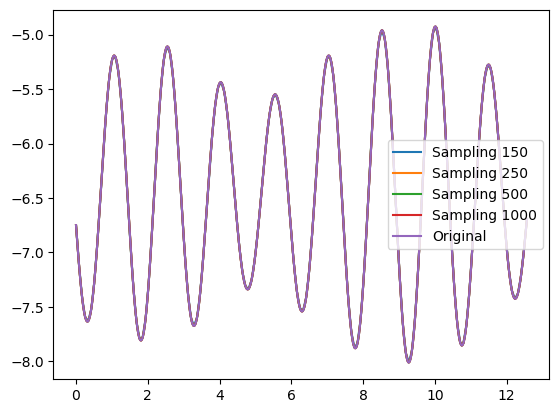

In [29]:
# Define a list of labels (legend) to identify the signals generated with different sampling sizes.
legend = ["Sampling 150", "Sampling 250", "Sampling 500", "Sampling 1000"]

# Define a list of lengths (number of points) for the different sampling sizes.
lengths = [150, 250, 500, 1000]

# Loop to plot each of the signals generated with different sampling sizes.
for i in range(len(legend)):
    # Plot the signal 'ly[i]' corresponding to the sampling size defined in 'lengths[i]'.
    plt.plot(np.linspace(x[0], x[-1], lengths[i]), ly[i], label=legend[i])
    
    # Add a legend to identify the signal with its corresponding label.
    plt.legend()

# Finally, plot the original signal (super-sampling) 'y' to compare it with the lower resolution versions.
plt.plot(x, y, label="Original")

# Add a legend for the original signal and ensure all legends are displayed.
plt.legend()
